### Imports and functions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import tifffile as T

from functions.utilities import get_umap, adjust_box_widths

import warnings 
warnings.filterwarnings('ignore')

### Reading input data

In [2]:
df = pd.read_excel("Data/IFN_morpho_lipid_data.xlsx") # Replace with raw data file for IFN
df1=df.drop(columns=['Groups','PC1','PC2', 'PC3', 'PC4', 'Location_Center_X', 'Location_Center_Y'], axis=1)#[df['Groups']=='s1w2']

df1_norm = (df1-df1.min())/(df1.max()-df1.min())


In [3]:
lipid_cols = ["Intensity_546.3", "Intensity_688.4", "Intensity_758.6", "Intensity_789.6"]
df1_sel_morph=df1_norm.drop(lipid_cols, axis=1) # To select only morphology columns for umap
df1_sel_lipids = df1_norm[lipid_cols]


### Generating UMAP embeddings

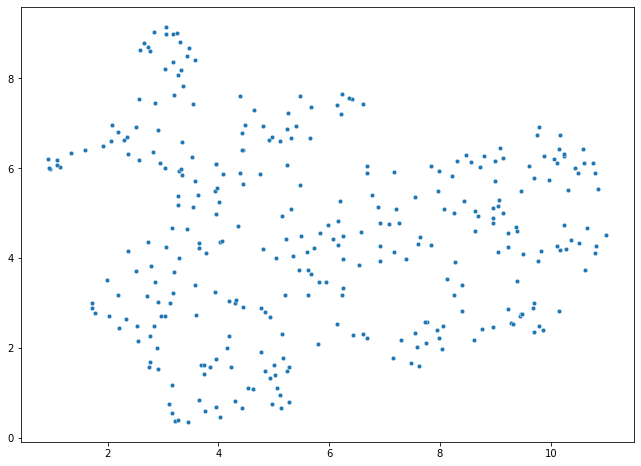

In [4]:
## For generating UMAP embeddings
emb,plot_df=get_umap(df1_sel_morph)

In [5]:
## For consistency, 
## we have saved the generated UMAP embeddings to a file.
## Loading the saved embeddings

emb=pd.read_csv("Data/umap_embeddings.csv")
emb.columns=['UMAP_1','UMAP_2']

### Clustering based on UMAP embeddings

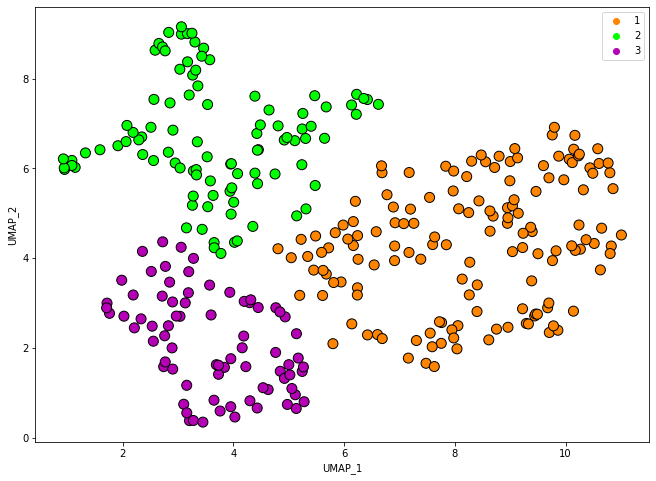

In [6]:
model = AgglomerativeClustering(n_clusters=3)
pred_y = model.fit_predict(emb[['UMAP_1','UMAP_2']])
pred_y=pred_y+1

color_dict = {1:"#ff8500", 2:"#00ff00", 3:"#b600b6"}

plt.figure(figsize=(11,8))
sns_plt = sns.scatterplot(
    x=emb['UMAP_1'], 
    y=emb['UMAP_2'],
    hue=pred_y,
    palette=color_dict,
    edgecolor='k',
    linewidth=1,
    s=100,
)


In [7]:
df['Clusters'] = pred_y

### Color-coding UMAP embedding based on lipid intensities

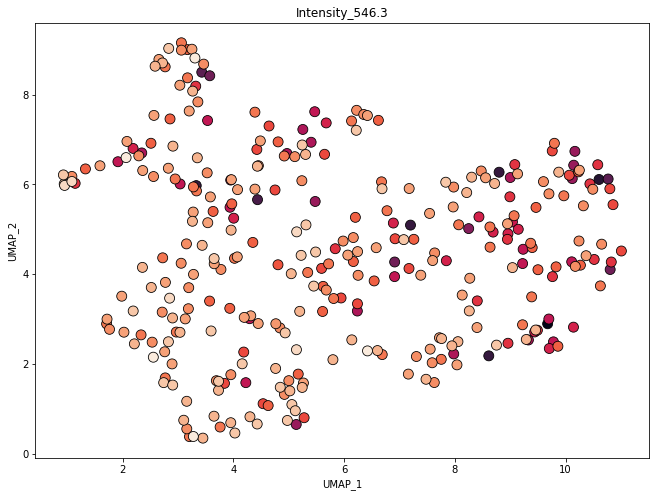

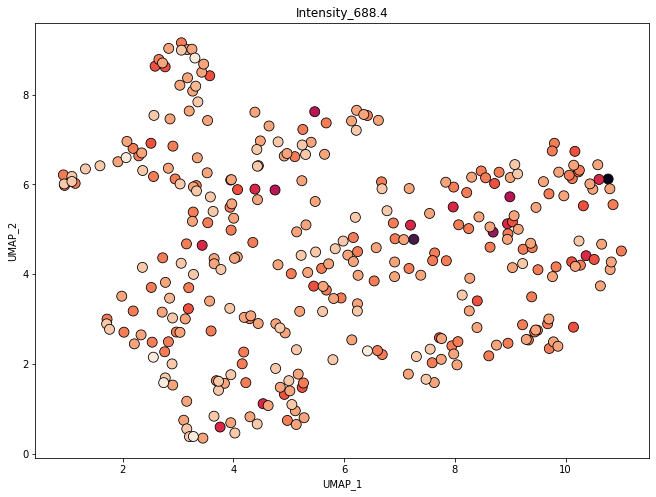

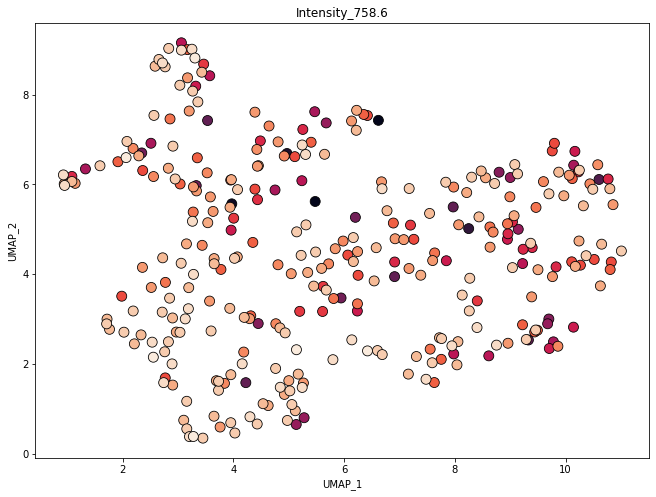

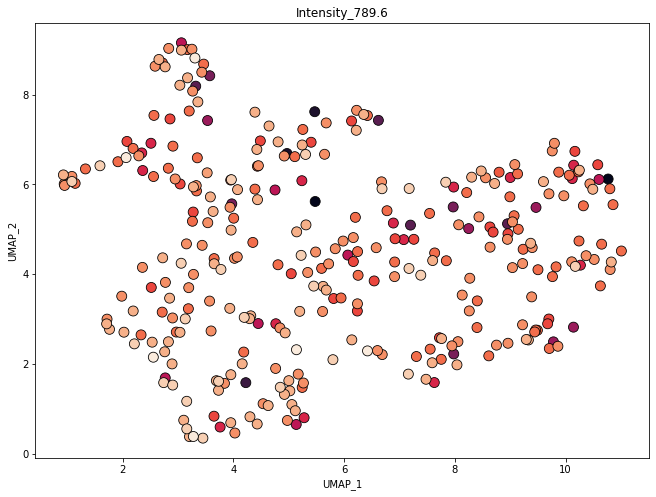

In [8]:
for i in lipid_cols:
    emb['Categ']=df1_sel_lipids[i]
    emb1=emb.sort_values(['Categ'], ascending=False)
    plt.figure(figsize=(11,8))
    ax=sns.scatterplot(x=emb1['UMAP_1'],y=emb1['UMAP_2'],
                       hue=emb1['Categ'],
                       legend=None,
                       palette="rocket_r",
                       edgecolor='k',
                       linewidth=0.8,
                       s=100)
    ax.set(title=i)


### Generating box-plots

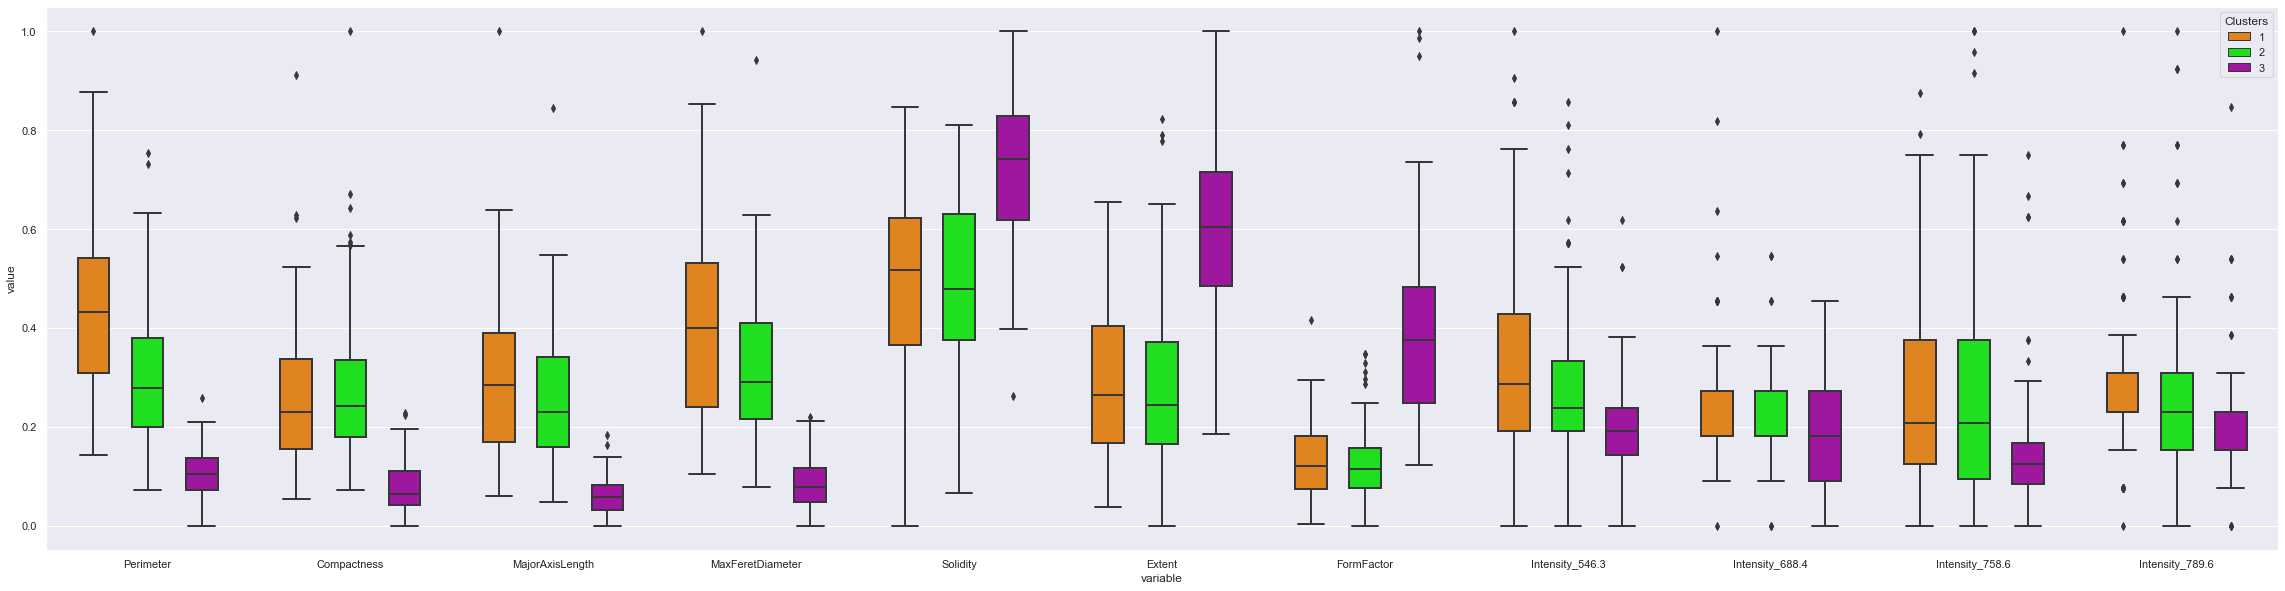

In [9]:
df1_box=df1_norm[['Perimeter', 'Compactness', 'MajorAxisLength', 'MaxFeretDiameter', 'Solidity', 'Extent', 'FormFactor', 'Intensity_546.3','Intensity_688.4','Intensity_758.6','Intensity_789.6']]

df1_box['Clusters'] = pred_y 

df1_box2=pd.melt(df1_box, id_vars=['Clusters'], value_vars=['Perimeter', 'Compactness', 'MajorAxisLength', 'MaxFeretDiameter', 'Solidity', 'Extent', 'FormFactor', 'Intensity_546.3','Intensity_688.4','Intensity_758.6','Intensity_789.6'])

color_dict = {1:"#ff8500", 2:"#00ff00", 3:"#b600b6"}

fig = plt.figure(figsize=(40,10))
sns.set(style="darkgrid")
ax = sns.boxplot(y='value', x='variable', 
            data=df1_box2, 
            hue='Clusters',
            palette=color_dict,
            linewidth=2,
            width=0.8)

adjust_box_widths(fig, 0.6)

### Color coding images using cluster assignments for cells

In [10]:
fn1 = r'images/input/S1W2.tif'
fn2 = r'images/input/maskimage.tiff'
fno = r'images/output/cluster.tif'


In [11]:
img = T.imread(fn1)
arr = T.imread(fn2)
clusterVals = np.asarray(df['Clusters'])


In [12]:
## Defining number of clusters
num_clusters = len(np.unique(clusterVals))
ny,nx = arr.shape
nz = int(arr.max())

clusterMin = clusterVals.min()
clusterMax = clusterVals.max()
    
rng = np.array([0.5,1.5,2.5,3.5])

out = np.zeros((num_clusters,ny,nx),dtype=np.int16)

for i in range(nz):
    a = clusterVals[i]
    msk = (arr==(i+1))
    aro = msk*img

    for j in range(num_clusters):
        b = rng[j]
        c = rng[j+1]
        if ((a>b)and(a<c)):
            out[num_clusters-j-1] += aro

T.imsave(fno,out)
